CS189/289A Introduction to Machine Learning
Spring 2023 - UCB - Shewchuk

I don't own this material; I am auditing the course using the material publically available on the course website here: https://people.eecs.berkeley.edu/~jrs/189/

To the best of my knowledge, all work here is my own except where noted.

HW1 Data, SVMs, Hyperparameter Tuning, K-Fold CV, Kaggle, Hard-Margin SVMs

In [51]:
#libraries
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from scipy import io

In [7]:
# This file is in scripts/load.py
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")

for data_name in ["mnist", "spam", "cifar10"]:
    data = np.load(f"C:/ML_learning/berkeley_cs189_introml/hw/hw1/data/{data_name}-data.npz") #running locally, path needs to be edited otherwise
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 1, 28, 28)
training_data (60000, 1, 28, 28)
training_labels (60000,)

loaded spam data!
test_data (1000, 32)
training_data (4172, 32)
training_labels (4172,)

loaded cifar10 data!
test_data (10000, 3072)
training_data (50000, 3072)
training_labels (50000,)


2. Data Partitioning

Rarely will you receive “training” data and “validation” data; usually you will have to partition available labeled data yourself. In this question, you will shuffle and partition each of the datasets in the assignment. Shuffling prior to splitting crucially ensures that all classes are represented in your partitions. For this question, please do not use any functions available in sklearn.
(a) For the MNIST dataset, write code that sets aside 10,000 training images as a validation set.
(b) For the spam dataset, write code that sets aside 20% of the training data as a validation set.
(c) For the CIFAR-10 dataset, write code that sets aside 5,000 training images as a validation set.

In [35]:
#data is provided as .npz files
#use 'with' to handle file opening and closing

#data is as Python dictionary, with three fields:
#training_data (rows: samples, columns: features)
#training_labels (rows: samples, column: label)
#test_data (rows:samples, columns: features)

def loadnpz(filename):
    path = 'C:/ML_learning/berkeley_cs189_introml/hw/hw1/data/'
    with np.load(path+filename) as data: 
        test = data["test_data"]
        training = data["training_data"]
        labels = data["training_labels"]
        #print (test.shape, training.shape, labels.shape)

    return test,training,labels

For MNIST, we need to shuffle and set 10,000 training images as validation set (without using sklearn functions)

In [41]:
def shuffle_validation_num(training_data, training_labels, n):
    # randomly select n data entries and returns training, training label, validation, validation label
    # @in: data, labels, number to set aside
    # @out: training_x, training_y, validation_x, validation_y
    rng = np.random.default_rng() #can use seed= for reproducible results
    assert(n>=0)

    indexes = np.arange(training_labels.shape[0])
    rng.shuffle(indexes)
    td = training_data[indexes[n:]]
    vd = training_data[indexes[:n]]
    tl = training_labels[indexes[n:]]
    vl = training_labels[indexes[:n]]

    return td,tl,vd,vl

def shuffle_validation_pct(training_data, training_labels, pct):
    # randomly select n data entries and returns training, training label, validation, validation label
    # @in: data, labels, percent to set aside
    # @out: training_x, training_y, validation_x, validation_y
    rng = np.random.default_rng() #can use seed= for reproducible results
    assert(pct>=0 and pct<=1)

    n = training_labels.shape[0]
    validation_n = int(n * pct // 1) #round down
    indexes = np.arange(n)
    rng.shuffle(indexes)
    td = training_data[indexes[validation_n:]]
    vd = training_data[indexes[:validation_n]]
    tl = training_labels[indexes[validation_n:]]
    vl = training_labels[indexes[:validation_n]]

    return td,tl,vd,vl

In [68]:
## 2A MNIST
mn_te,mn_tr,mn_label = loadnpz("mnist-data.npz")
mn_td,mn_tl,mn_vd,mn_vl = shuffle_validation_num(mn_tr,mn_label,10000)
mn_test = mn_te
print(mn_td.shape,mn_tl.shape,mn_vd.shape,mn_vl.shape) #should be (50000, 1, 28, 28) (50000,) (10000, 1, 28, 28) (10000,)

(50000, 1, 28, 28) (50000,) (10000, 1, 28, 28) (10000,)


In [69]:
## 2B
sp_te,sp_tr,sp_label = loadnpz("spam-data.npz")
sp_td,sp_tl,sp_vd,sp_vl = shuffle_validation_pct(sp_tr,sp_label,0.2)
sp_test = sp_te
print(sp_td.shape,sp_tl.shape,sp_vd.shape,sp_vl.shape) #(3338, 32) (3338,) (834, 32) (834,)

(3338, 32) (3338,) (834, 32) (834,)


In [70]:
## 2C CIFAR
ci_te,ci_tr,ci_label = loadnpz("cifar10-data.npz")
ci_td,ci_tl,ci_vd,ci_vl = shuffle_validation_num(ci_tr,ci_label,5000)
ci_test = ci_te
print(ci_td.shape,ci_tl.shape,ci_vd.shape,ci_vl.shape) #should be (45000, 3072) (45000,) (5000, 3072) (5000,)

(45000, 3072) (45000,) (5000, 3072) (5000,)


All data shuffled!  On to the next problem.

3 Support Vector Machines: Coding
We will use linear Support Vector Machines to classify our datasets. For images, we will use the
simplest of features for classification: raw pixel brightness values. In other words, our feature
vector for an image will be a row vector with all the pixel values concatenated in a row major (or
column major) order.

You may use sklearn only for the SVM model and the sklearn.metrics.accuracy_score
function. Everything else (generating plots) must be done without the use of sklearn

Deliverable: For this question, you should include three plots showing number of examples versus
training and validation accuracy for each of the datasets. Additionally, be sure to include your code
in the “Code Appendix” portion of your write-up.

In [59]:
def SVM_validate_loop(model,X,Y,params):
    tr_acc = []
    va_acc = []
    for param in params:
        td, tl, vd, vl = shuffle_validation_num(X, Y, param)
        model.fit(td,tl) #fit
        yhat = model.predict(td)
        tr_acc.append(accuracy_score(yhat,tl)) #training accuracy
        yhat = model.predict(vd)
        va_acc.append(accuracy_score(yhat,vl)) #validation accuracy
    return tr_acc, va_acc


In [92]:
mnist_parameters2 = [100,200,500,1000,2000,5000,10000]
spam_parameters2 = [100,200,500,1000,2000,4162]
cifar_parameters2 = [100,200,500,1000,2000,5000]
plot_steps = [1,2,3,4,5,6,7]

In [71]:
#3A MNIST
mnist_parameters = [59900,59800,59500,59000,58000,55000,50000]

mnist_classify = svm.LinearSVC()
mn_tr_raw = mn_tr / 255. #
print(mn_tr_raw.shape)
mn_tr_raw = np.reshape(mn_tr_raw,(60000,784))
print(mn_tr_raw.shape)
mnist_tr_acc, mnist_va_acc = SVM_validate_loop(mnist_classify,mn_tr_raw,mn_label,mnist_parameters)
for i in range(len(mnist_parameters)):
    print(60000-mnist_parameters[i],mnist_tr_acc[i],mnist_va_acc[i])

(60000, 1, 28, 28)
(60000, 784)


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_clas

100 0.18 0.1127212020033389
200 0.135 0.10130434782608695
500 0.384 0.32026890756302523
1000 0.641 0.6330338983050847
2000 0.663 0.653448275862069
5000 0.7554 0.7444181818181819
10000 0.7774 0.77892


In [87]:
#3B SPAM
spam_parameters = [4072,3972,3672,3172,2172,10] #size of validation set, not training set!

spam_classify = svm.LinearSVC()

spam_tr_acc, spam_va_acc = SVM_validate_loop(spam_classify,sp_tr,sp_label,spam_parameters)
for i in range(len(spam_parameters)):
    print(4172-spam_parameters[i],spam_tr_acc[i],spam_va_acc[i])

100 0.73 0.7333005893909627
200 0.835 0.769889224572004
500 0.824 0.7998366013071896
1000 0.807 0.8020176544766708
2000 0.815 0.8116942909760589
4162 0.8099471407976934 0.9


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

In [88]:
#3C CIFAR
cifar_parameters = [49900,49800,49500,49000,48000,45000] #size of validation set, not training set!

cifar_classify = svm.LinearSVC()

cifar_tr_acc, cifar_va_acc = SVM_validate_loop(cifar_classify,ci_tr,ci_label,cifar_parameters)
for i in range(len(cifar_parameters)):
    print(50000-cifar_parameters[i],cifar_tr_acc[i],cifar_va_acc[i])

c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

100 1.0 0.22226452905811622
200 1.0 0.22734939759036144
500 1.0 0.2279191919191919
1000 0.999 0.2386938775510204
2000 0.995 0.239875
5000 0.7682 0.23735555555555554


We now have our results; time to plot them.

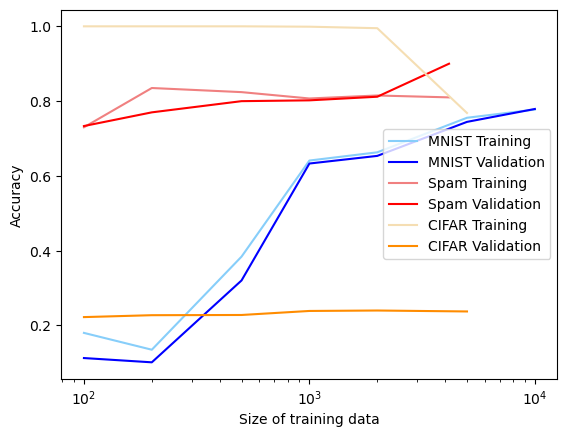

In [101]:
plt.plot(mnist_parameters2,mnist_tr_acc, color='lightskyblue', label="MNIST Training")
plt.plot(mnist_parameters2,mnist_va_acc, color='blue', label="MNIST Validation")
plt.plot(spam_parameters2,spam_tr_acc, color = 'lightcoral', label="Spam Training")
plt.plot(spam_parameters2,spam_va_acc, color = 'red', label="Spam Validation")
plt.plot(cifar_parameters2,cifar_tr_acc, color = 'wheat', label = "CIFAR Training")
plt.plot(cifar_parameters2,cifar_va_acc, color = 'darkorange', label = "CIFAR Validation")
plt.xlabel("Size of training data")
plt.ylabel("Accuracy")
plt.legend(loc='right')
plt.xscale('log')
plt.show()

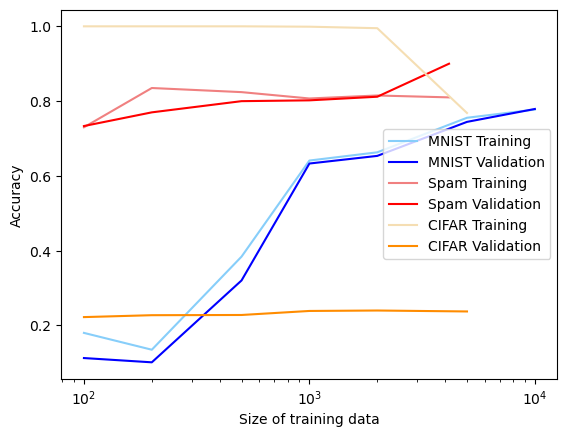

We see here the results of fitting a LinearSVM model to the three classification problems.  Overall, MNIST and Spam did fairly well, reaching 80%+ accuracy on the validation data.  But CIFAR is less than 25%, suggesting that LinearSVM is not capable of classifying this data.

Other results indicate that Spam requires little training data to be useful.  In fact, there seems to be some slight overfitting as the training sample increases.  In contrast, MNIST doesn't appear to be overfitting, so in the next HW problem it will be interesting to see whether performance improves if we decrease the regularization.  Important to note, however, that there is a lot of randomness in selecting the sample, so the improvements in MNIST Training and Validation could be just due to lucky sampling.

4 Hyperparameter Tuning
In the previous problem, you learned parameters for a model that classifies the data. Many classifiers also have hyperparameters that you can tune to influence the parameters. In this problem,
we’ll determine good values for the regularization parameter C in the soft-margin SVM algorithm.

The use of automatic hyperparameter optimization libraries is prohibited for this part of the
homework.

Deliverable: For the MNIST dataset, find the best C value. In your report, list at least 8 C values
you tried, the corresponding accuracies, and the best C value. You should try a geometric sequence
of C values (not an arithmetic sequence). As in the previous problem, for performance reasons,
you are required to train with at least 10,000 training examples. You can train on more if you like,
but it is not required. Again, reference any code you used to perform a hyperparameter sweep in
the code appendix.

In [110]:
#default value of C: 1
#initial proposed trial Cs: [0.01,0.1,0.5,1,2,10]
#follow-up Cs: [?, ?, 100] - depending on results

def SVM_tuning(X,Y,reg_param):
    const_n = 60000-10000
    tr_acc_list, va_acc_list = [],[]
    for c in reg_param:
        print(c)
        model = svm.LinearSVC(C=c)
        tr_acc, va_acc = SVM_validate_loop(model,X,Y,np.array([const_n]))
        tr_acc_list.append(tr_acc[0])
        va_acc_list.append(va_acc[0])
    return tr_acc_list, va_acc_list

In [113]:
initial_Cs = [0.01,0.1,0.5,1,10,50,100,1000]

tr_C, va_C = SVM_tuning(mn_tr_raw,mn_label,initial_Cs)
for i in range(len(initial_Cs)):
    print(initial_Cs[i],tr_C[i],va_C[i])

0.01


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.1


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.5


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


1


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


10


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


50


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


100


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1000


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.01 0.2071 0.19912
0.1 0.6206 0.61016
0.5 0.7486 0.74624
1 0.7852 0.76606
10 0.8668 0.86072
50 0.8943 0.88692
100 0.9082 0.89186
1000 0.9181 0.89582


0.01 0.2071 0.19912
0.1 0.6206 0.61016
0.5 0.7486 0.74624
1 0.7852 0.76606
10 0.8668 0.86072
50 0.8943 0.88692
100 0.9082 0.89186
1000 0.9181 0.89582

Surprisingly, we see monotonic improvement with higher C, suggesting that more regularization leads to better performance on not only the validation set, but the training set as well.  Worth noting that the time required for higher regularizations increases substantially, from almost instant at C=.01 to taking tens of seconds by C=1000.

In fact, the algorithm often fails to converge starting from C in [50,100] interval.  Even though results are improving, this could be because the training is taking many more steps to converge.  Further experimentation with higher C seems counterproductive.

5.  K-Fold Cross-Validation
For smaller datasets (e.g., the spam dataset), the validation set contains fewer examples, and our
estimate of our accuracy might not be accurate—the estimate has high variance. A way to combat
this is to use k-fold cross-validation.

Use of automatic cross-validation libraries is prohibited for this part of the homework.

Deliverable: For the spam dataset, use 5-fold cross-validation to find and report the best C value.
In your report, list at least 8 C values you tried, the corresponding accuracies, and the best C value.
Again, please include your code for cross validation or include a reference to its location in your
code appendix

In [179]:
#total training samples: 4172
#5-fold partitioning: 834, 834, 834, 835, 835
def data_fold(X,Y,indexes, i):
    m = [0, 834, 1668, 2503, 3338] # loop to evaluate validation score 5 times
    n = [834,1668,2503,3338,4172]
    k = len(m) # k = 4

    a = m[i]
    b = n[i]

    td_ix = []
    tl_ix = []

    if i != 0:
        td_ix = indexes[:a]
        tl_ix = indexes[:a]
    if i != k:
        if i == 0:
            td_ix = indexes[b:]
            tl_ix = indexes[b:]
        else:
            td_ix = [*td_ix, *indexes[b:]] #PEP448 list addition, Python3.5
            tl_ix = [*tl_ix, *indexes[b:]]

    return X[td_ix],Y[tl_ix],X[indexes[a:b]],Y[indexes[a:b]]  #k x (834xd) arrays of data

def KFoldCV(X,Y,reg_param):
    rng = np.random.default_rng() #can use seed= for reproducible results
    k = 5

    indexes = np.arange(Y.shape[0])
    rng.shuffle(indexes)

    tr_acc, va_acc = [], []


    for c in reg_param:
        for i in range(k):
            td,tl,vd,vl = data_fold(X,Y,indexes,i)
            model = svm.LinearSVC(C=c)
            model.fit(td,tl) #fit
            yhat = model.predict(td)
            tr_acc.append(accuracy_score(yhat,tl)) #training accuracy
            yhat = model.predict(vd)
            va_acc.append(accuracy_score(yhat,vl)) #validation accuracy
            print(c, "fold #", i, va_acc[-1])

        if c == reg_param[0]:
            tr_acc_list = np.array([tr_acc])
            va_acc_list = np.array([va_acc])
        else:
            tr_acc_list = np.vstack((tr_acc_list,np.array([tr_acc])))
            va_acc_list = np.vstack((va_acc_list,np.array([va_acc])))
        print(va_acc_list)
        tr_acc = []
        va_acc = []
    return tr_acc_list, va_acc_list

spam_Cs = [0.01,0.1,0.5,1,10,100,1000,10000]

In [181]:
spam_tr_list, spam_va_list = KFoldCV(sp_tr,sp_label, spam_Cs)
means = np.mean(spam_va_list,axis=1)

for i in range(spam_va_list.shape[0]):
    print(f"C of {spam_Cs[i]}: mean validation accuracy {means[i]}")

c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

0.01 fold # 0 0.8033573141486811
0.01 fold # 1 0.7913669064748201


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

0.01 fold # 2 0.7904191616766467
0.01 fold # 3 0.8
0.01 fold # 4 0.802158273381295
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]]
0.1 fold # 0 0.8045563549160671


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

0.1 fold # 1 0.7949640287769785
0.1 fold # 2 0.7988023952095809
0.1 fold # 3 0.8


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

0.1 fold # 4 0.8105515587529976
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]]
0.5 fold # 0 0.8129496402877698
0.5 fold # 1 0.7985611510791367


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

0.5 fold # 2 0.8035928143712575
0.5 fold # 3 0.8
0.5 fold # 4 0.8141486810551559
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]
 [0.81294964 0.79856115 0.80359281 0.8        0.81414868]]


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

1 fold # 0 0.8189448441247003
1 fold # 1 0.7961630695443646
1 fold # 2 0.8011976047904191


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

1 fold # 3 0.8035928143712575
1 fold # 4 0.8105515587529976
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]
 [0.81294964 0.79856115 0.80359281 0.8        0.81414868]
 [0.81894484 0.79616307 0.8011976  0.80359281 0.81055156]]
10 fold # 0 0.8105515587529976


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

10 fold # 1 0.8057553956834532
10 fold # 2 0.8047904191616766
10 fold # 3 0.8095808383233533


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

10 fold # 4 0.8129496402877698
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]
 [0.81294964 0.79856115 0.80359281 0.8        0.81414868]
 [0.81894484 0.79616307 0.8011976  0.80359281 0.81055156]
 [0.81055156 0.8057554  0.80479042 0.80958084 0.81294964]]
100 fold # 0 0.7949640287769785
100 fold # 1 0.8033573141486811


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

100 fold # 2 0.8287425149700599
100 fold # 3 0.8083832335329342
100 fold # 4 0.7961630695443646
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]
 [0.81294964 0.79856115 0.80359281 0.8        0.81414868]
 [0.81894484 0.79616307 0.8011976  0.80359281 0.81055156]
 [0.81055156 0.8057554  0.80479042 0.80958084 0.81294964]
 [0.79496403 0.80335731 0.82874251 0.80838323 0.79616307]]


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha

1000 fold # 0 0.7961630695443646
1000 fold # 1 0.7338129496402878
1000 fold # 2 0.7856287425149701


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1000 fold # 3 0.7712574850299401
1000 fold # 4 0.7446043165467626
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]
 [0.81294964 0.79856115 0.80359281 0.8        0.81414868]
 [0.81894484 0.79616307 0.8011976  0.80359281 0.81055156]
 [0.81055156 0.8057554  0.80479042 0.80958084 0.81294964]
 [0.79496403 0.80335731 0.82874251 0.80838323 0.79616307]
 [0.79616307 0.73381295 0.78562874 0.77125749 0.74460432]]
10000 fold # 0 0.7314148681055156


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


10000 fold # 1 0.7733812949640287
10000 fold # 2 0.7772455089820359
10000 fold # 3 0.7173652694610778


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


10000 fold # 4 0.7829736211031175
[[0.80335731 0.79136691 0.79041916 0.8        0.80215827]
 [0.80455635 0.79496403 0.7988024  0.8        0.81055156]
 [0.81294964 0.79856115 0.80359281 0.8        0.81414868]
 [0.81894484 0.79616307 0.8011976  0.80359281 0.81055156]
 [0.81055156 0.8057554  0.80479042 0.80958084 0.81294964]
 [0.79496403 0.80335731 0.82874251 0.80838323 0.79616307]
 [0.79616307 0.73381295 0.78562874 0.77125749 0.74460432]
 [0.73141487 0.77338129 0.77724551 0.71736527 0.78297362]]
C of 0.01: mean validation accuracy 0.7974603311362886
C of 0.1: mean validation accuracy 0.8017748675311248
C of 0.5: mean validation accuracy 0.805850457358664
C of 1: mean validation accuracy 0.8060899783167479
C of 10: mean validation accuracy 0.8087255704418501
C of 100: mean validation accuracy 0.8063220321946037
C of 1000: mean validation accuracy 0.766293312655265
C of 10000: mean validation accuracy 0.7564761125231552


c:\Users\zacha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Results:

C of 0.01: mean validation accuracy 0.7974603311362886
C of 0.1: mean validation accuracy 0.8017748675311248
C of 0.5: mean validation accuracy 0.805850457358664
C of 1: mean validation accuracy 0.8060899783167479
C of 10: mean validation accuracy 0.8087255704418501
C of 100: mean validation accuracy 0.8063220321946037
C of 1000: mean validation accuracy 0.766293312655265
C of 10000: mean validation accuracy 0.7564761125231552

After C~100, the accuracy starts to go down - seems to be because of convergence errors.